In [177]:
import json
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [178]:
# Define the list of years to analyze
years_to_analyze = [2023, 2019, 2014]

In [179]:
# Check if file exists
file_path = '../data/observed_solar_cycle_indices.json'
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Load JSON data
with open(file_path, 'r') as f:
    solar_data = json.load(f)

# Filter data
filtered_data = []
for item in solar_data:
    filtered_data.append({
        'time-tag': item['time-tag'],
        'ssn': item['ssn'],
        'smoothed_ssn': item['smoothed_ssn']
    })

# Convert JSON data to pandas DataFrame
df_solar = pd.DataFrame(filtered_data)

# Convert time-tag to datetime
df_solar['time-tag'] = pd.to_datetime(df_solar['time-tag'])

df_solar['time-tag'] = df_solar['time-tag'].dt.to_period('M')

# Filter data for the specified years
df_solar = df_solar[df_solar['time-tag'].dt.year.isin(years_to_analyze)]

print(df_solar)

     time-tag    ssn  smoothed_ssn
3180  2014-01  117.0         109.3
3181  2014-02  146.1         110.5
3182  2014-03  128.7         114.3
3183  2014-04  112.5         116.4
3184  2014-05  112.5         115.0
3185  2014-06  102.9         114.1
3186  2014-07  100.2         112.6
3187  2014-08  106.9         108.3
3188  2014-09  130.0         101.9
3189  2014-10   90.0          97.3
3190  2014-11  103.6          94.7
3191  2014-12  112.9          92.2
3240  2019-01    7.7           5.4
3241  2019-02    0.8           5.0
3242  2019-03    9.4           4.6
3243  2019-04    9.1           4.3
3244  2019-05    9.9           3.9
3245  2019-06    1.2           3.7
3246  2019-07    0.9           3.5
3247  2019-08    0.5           3.4
3248  2019-09    1.1           3.1
3249  2019-10    0.4           2.6
3250  2019-11    0.5           2.0
3251  2019-12    1.5           1.8
3288  2023-01  144.4         113.3
3289  2023-02  111.3         117.8
3290  2023-03  123.3         121.0
3291  2023-04   97.6

In [180]:
# Check if file exists
file_path = '../data/GRIFEX/resets.csv'
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Load CSV data
df_resets = pd.read_csv(file_path)

# Convert Time to datetime
df_resets['Time'] = pd.to_datetime(df_resets['Time'])

# Normalize time to midnight
df_resets['Time'] = df_resets['Time'].dt.normalize()

# Filter data for the specified years
df_resets = df_resets[df_resets['Time'].dt.year.isin(years_to_analyze)]

print(df_resets)

           Time  resets
0    2019-01-05   675.0
1    2019-01-06   677.0
2    2019-01-07   677.0
3    2019-01-08   678.0
4    2019-01-09   678.0
...         ...     ...
1817 2023-12-27  1806.0
1818 2023-12-28  1806.0
1819 2023-12-29  1807.0
1820 2023-12-30  1808.0
1821 2023-12-31  1808.0

[726 rows x 2 columns]


In [181]:
# Group by year and month, and calculate median of resets
df_resets['Month'] = df_resets['Time'].dt.to_period('M')
median_resets = df_resets.groupby('Month')['resets'].median()

# Reset the index for median_resets
median_resets = median_resets.reset_index()

print(median_resets)

      Month  resets
0   2019-01   684.0
1   2019-02   698.5
2   2019-03   723.0
3   2019-04   742.0
4   2019-05   760.0
5   2019-06   782.5
6   2019-07   806.0
7   2019-08   829.0
8   2019-09   848.5
9   2019-10   870.0
10  2019-11   895.5
11  2019-12   919.0
12  2023-01  1607.0
13  2023-02  1624.5
14  2023-03  1642.0
15  2023-04  1659.5
16  2023-05  1677.0
17  2023-06  1698.5
18  2023-07  1721.0
19  2023-08     2.0
20  2023-09     0.0
21  2023-10  1749.0
22  2023-11  1774.0
23  2023-12  1798.0


In [182]:
# Merge median_resets and df_solar
merged_df = pd.merge(median_resets, df_solar, left_on='Month',
                     right_on='time-tag')

# Calculate correlation
correlation = merged_df['resets'].corr(merged_df['ssn'])

# Print correlation
print(f"Correlation between resets and ssn: {correlation}")

Correlation between resets and ssn: 0.5448282190035044


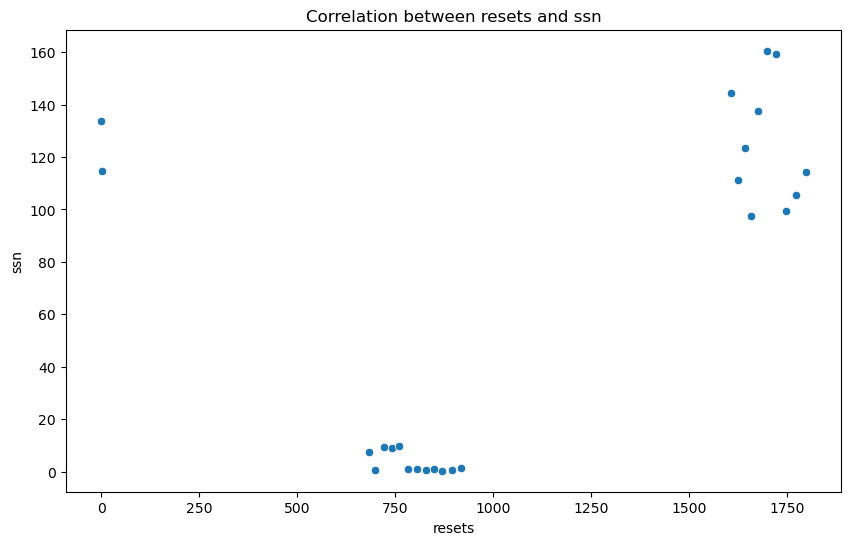

In [183]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='resets', y='ssn')
plt.title('Correlation between resets and ssn')
plt.show()

Moderate linear relationship between resets and ssn.
          resets       ssn
resets  1.000000  0.544828
ssn     0.544828  1.000000


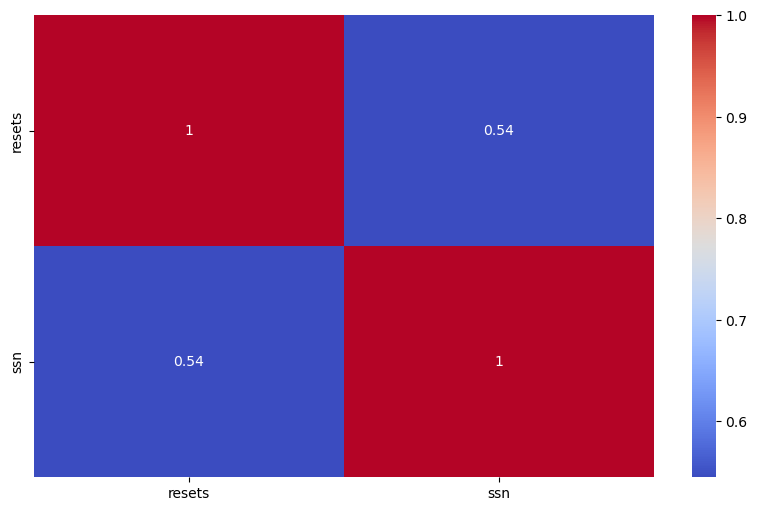

In [184]:
# Analyze correlation
if abs(correlation) > 0.9:
    print("Strong linear relationship between resets and ssn.")
elif abs(correlation) > 0.5:
    print("Moderate linear relationship between resets and ssn.")
else:
    print("Little to no linear relationship between resets and ssn.")

# Create a correlation matrix
corr_matrix = merged_df[['resets', 'ssn']].corr()

print(corr_matrix)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()
